Accuracy using LDA on test set using NCC CLassifier: 94.66666666666667


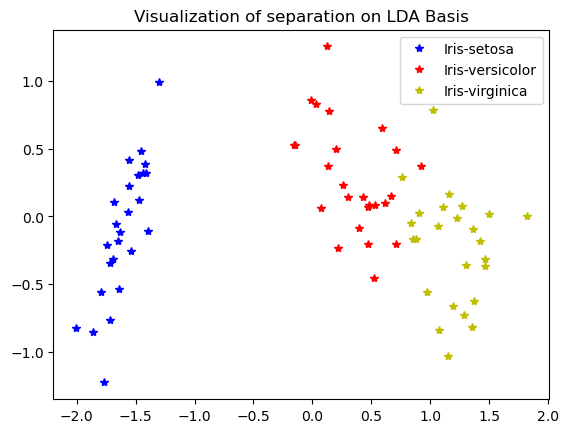

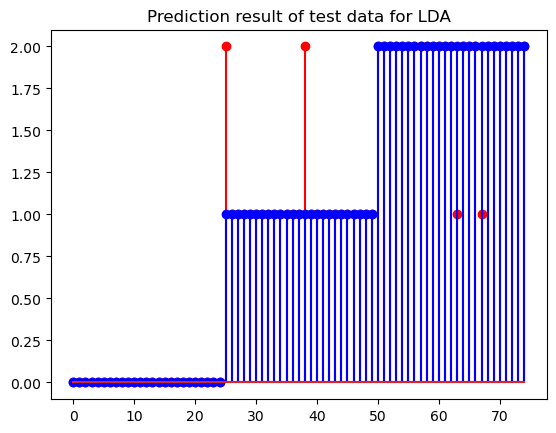

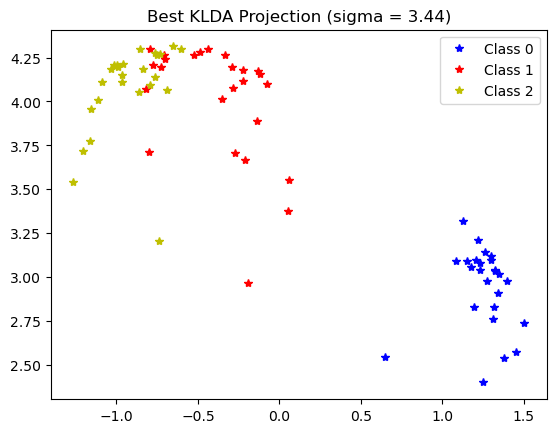

Accuracy using KLDA on test set using NCC Classifier: 97.33333333333334
Accuracy using LDA on Validation set using NCC Classifier: 97.73333333333333


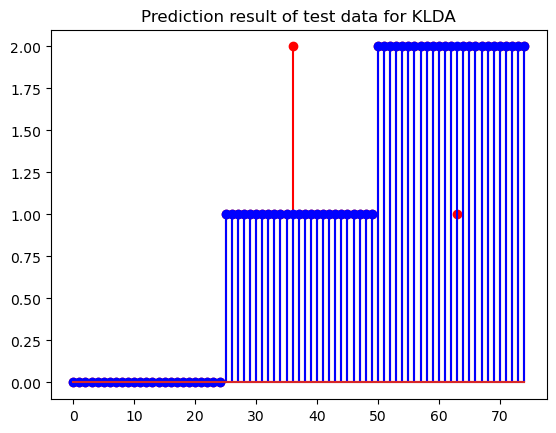

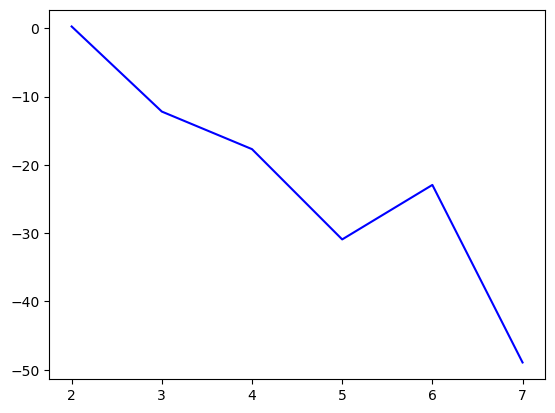

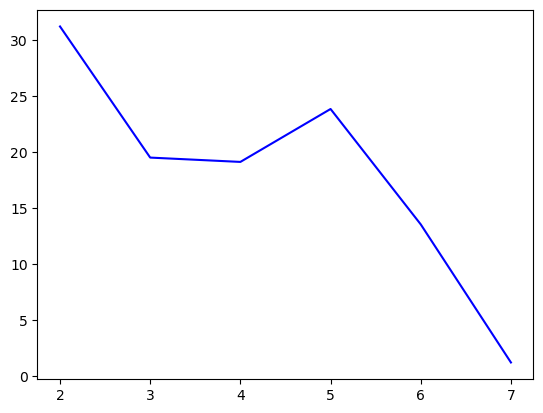

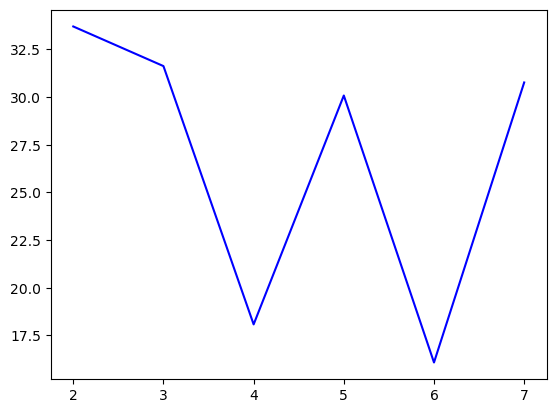

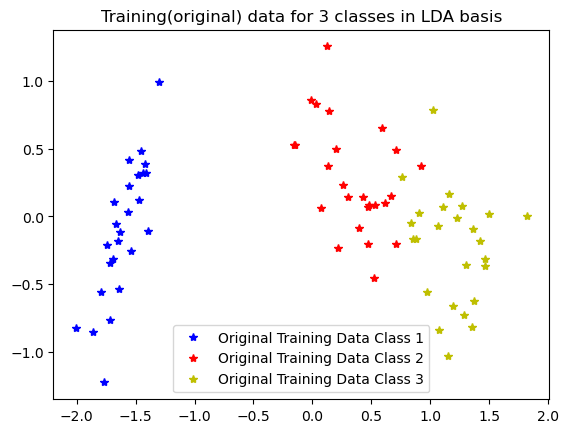

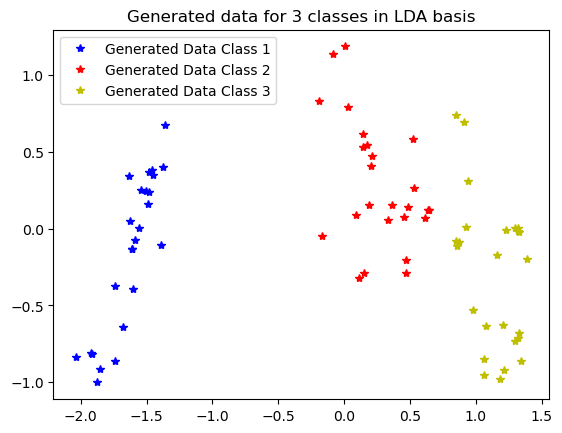

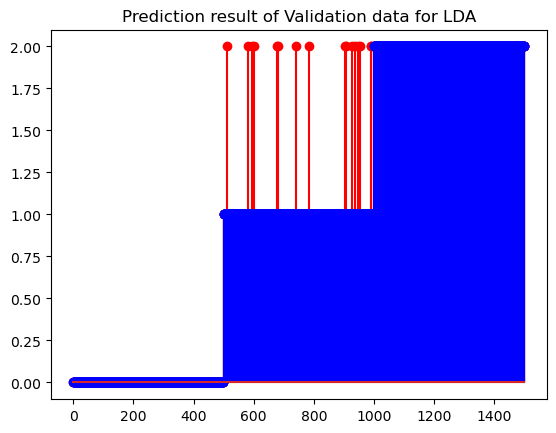

In [133]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from numpy.linalg import eig, inv, pinv,norm,eigh
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

np.random.seed(0)

#LDA attempt
def LDA(TRAINDATA1,TRAINDATA2,TRAINDATA3):
    
    # Calculation of means
    MEAN1 = np.mean(TRAINDATA1, axis=1)
    MEAN2 = np.mean(TRAINDATA2, axis=1)
    MEAN3 = np.mean(TRAINDATA3, axis=1)
    
    # Construction of Between-class scatter matrix
    C=(MEAN1+MEAN2+MEAN3)/3
    M1 = MEAN1[:, np.newaxis]  # shape (2,1)
    M2 = MEAN2[:, np.newaxis]
    M3 = MEAN3[:, np.newaxis]
    C = C[:, np.newaxis]       # shape (2,1)
    
    SB= 25*((((M1-C) @ (M1-C).T) + ((M2-C) @ (M2-C).T) + ((M3-C) @ (M3-C).T)))
    
    # Construction of Within-class scatter matrix
    SW = 25*(((TRAINDATA1 - M1) @ (TRAINDATA1 - M1).T +
          (TRAINDATA2 - M2) @ (TRAINDATA2 - M2).T) + (TRAINDATA3 - M3) @ (TRAINDATA3 - M3).T)
    # Solving the LDA eigenvalue problem
    eigvals, E = eig(pinv(SW) @ SB)
    
    # Sorting the Eigvalues/vectors in descending order of magnitude
    sorted_indices = np.argsort(eigvals)[::-1]
    # eigvals = eigvals[sorted_indices]
    # print(eigvals/np.sum(eigvals))#To Inspect as to how many features to take
    
    E=E[:,sorted_indices[:2]]
    
    #Visualization of distinction
    T1=E.T @ TRAINDATA1
    T2=E.T @ TRAINDATA2
    T3=E.T @ TRAINDATA3
    plt.figure()
    plt.plot(T1[0],T1[1],'b*',label='Iris-setosa')
    plt.plot(T2[0],T2[1],'r*',label='Iris-versicolor')
    plt.plot(T3[0],T3[1],'y*',label='Iris-virginica')
    plt.legend()
    plt.title("Visualization of separation on LDA Basis")
    return E,M1,M2,M3

def classify_with_NCC(Y, centroids):
    C = np.hstack(centroids)
    dists = np.linalg.norm(Y[:, :, np.newaxis] - C[:, np.newaxis, :], axis=0)
    return np.argmin(dists, axis=1)
    
#Read dataset
df = pd.read_csv(r"C:\Users\Venkat Raman\Downloads\Iris - Copy.csv")

#Analysis and EDA
#df.head(10)#general idea
#df.info()#Basic Info about features
#df.describe()#Basic Statistical Overview
Data_useful = df.drop(['Id'], axis=1)#Dropping useless Id column

#Conversion of Target Labels to numbers
target_encoder=OneHotEncoder(sparse_output=False)
target=target_encoder.fit_transform(df[['Species']])
t=[]
for i in range(len(target)):
    if(target[i][0]==1):
        t.append(0)
    elif(target[i][1]==1):
        t.append(1)
    else:
        t.append(2)
Data_useful['Species']=t #Adding it back to converted dataframe

#Visualizing features individually
# Data_useful.hist(bins=20, figsize=(10, 8))

#Visualizing Corellation and interdependence
# corr = Data_useful.corr()
# sns.heatmap(corr, annot=True, cmap='coolwarm')
# sns.pairplot(Data_useful)

#Standardiing and making input and target separations
X = Data_useful.drop(['Species'],axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X= np.array(X)
#Random split into test and train
perm=np.random.permutation(50)
X1_train = X[perm[:25]]
X2_train = X[perm[:25]+50]
X3_train = X[perm[:25]+100]

X1_test = X[perm[25:]]
X2_test = X[perm[25:]+50]
X3_test = X[perm[25:]+100]

X1_train=X1_train.T
X2_train=X2_train.T
X3_train=X3_train.T
X1_test=X1_test.T
X2_test=X2_test.T
X3_test=X3_test.T
t1_test = [t[i] for i in perm[25:]]
t2_test = [t[i + 50] for i in perm[25:]]
t3_test = [t[i + 100] for i in perm[25:]]

# #Plotting of train data
# for i in range(4):
#     for j in range(4):
#         if(i != j):
#             plt.figure()
#             plt.plot(X1_train[:,i],X1_train[:,j],'r*')
#             plt.plot(X2_train[:,i],X2_train[:,j],'b*')
#             plt.plot(X3_train[:,i],X3_train[:,j],'y*')

# #Plotting of test data
# for i in range(4):
#     for j in range(4):
#         if(i != j):
#             plt.figure()
#             plt.plot(X1_test[:,i],X1_test[:,j],'r*')
#             plt.plot(X2_test[:,i],X2_test[:,j],'b*')
#             plt.plot(X3_test[:,i],X3_test[:,j],'y*')            

#Projection of Test Data on LDA Basis and predicting using NCC
E_LDA,M1,M2,M3=LDA(X1_train,X2_train,X3_train)
Y1=(E_LDA.T @ X1_test)
Y2=(E_LDA.T @ X2_test)
Y3=(E_LDA.T @ X3_test)

M1 = (E_LDA.T @ M1)
M2 = (E_LDA.T @ M2)
M3 = (E_LDA.T @ M3)
# Classifying using nearest centroid
centroids = [M1,M2,M3]
PRED1 = classify_with_NCC(Y1, centroids)
PRED2 = classify_with_NCC(Y2, centroids)
PRED3 = classify_with_NCC(Y3, centroids)
PRED=np.concatenate((PRED1,PRED2,PRED3))
TEST_TARGET= np.concatenate((t1_test,t2_test,t3_test))
plt.figure()
plt.stem(PRED,'r-')
plt.stem(TEST_TARGET,'b-')
plt.title("Prediction result of test data for LDA")
acc_test_LDA = np.sum(PRED == TEST_TARGET)
acc_test_LDA=(acc_test_LDA/75)*100
print("Accuracy using LDA on test set using NCC CLassifier:",acc_test_LDA)

def gausskernel(x, y, sigma):
    return np.exp(-np.linalg.norm(x - y) ** 2 / (2 * sigma ** 2))

def KLDA(TRAINDATA1, TRAINDATA2, TRAINDATA3, TESTDATA1, TESTDATA2, TESTDATA3):
    TRAINDATA = np.hstack((TRAINDATA1, TRAINDATA2, TRAINDATA3))
    TESTDATA = np.hstack((TESTDATA1, TESTDATA2, TESTDATA3))

    labels_train = np.array([0]*25 + [1]*25 + [2]*25)
    labels_test = labels_train.copy()

    sigma_list = np.linspace(0.5,5,50)
    best_acc = 0
    best_sigma = None
    best_E = None
    best_train_proj = None
    best_test_proj = None
    best_pred_labels= None
    for sigma in sigma_list:
        # Gram matrix for training data
        G = np.zeros((75,75))
        for i in range(75):
            for j in range(75):
                G[i, j] = gausskernel(TRAINDATA[:, i], TRAINDATA[:, j], sigma)

        # Splitting Gram matrix class-wise for SB  and SW formation
        X1_kernel = G[:, :25]
        X2_kernel = G[:, 25:50]
        X3_kernel = G[:, 50:]

        # Class-wise mean vectors
        M1 = np.mean(X1_kernel, axis=1, keepdims=True)
        M2 = np.mean(X2_kernel, axis=1, keepdims=True)
        M3 = np.mean(X3_kernel, axis=1, keepdims=True)
        C = (M1 + M2 + M3) / 3

        # Scatter matrices
        SB = 25 * ((M1 - C) @ (M1 - C).T + (M2 - C) @ (M2 - C).T + (M3 - C) @ (M3 - C).T)
        SW = 25 * ((X1_kernel - M1) @ (X1_kernel - M1).T +
                   (X2_kernel - M2) @ (X2_kernel - M2).T +
                   (X3_kernel - M3) @ (X3_kernel - M3).T)

        # Solving the eigen value problem
        eigvals, eigvecs = eigh(pinv(SW) @ SB)
        idx = np.argsort(eigvals)[::-1]
        E = eigvecs[:, idx[:2]]

        # Projecting training data
        Y1 = E.T @ X1_kernel
        Y2 = E.T @ X2_kernel
        Y3 = E.T @ X3_kernel
        Y_train = np.hstack((Y1, Y2, Y3)).T

        # Centroids
        centroids = [np.mean(Y_train[labels_train == i], axis=0) for i in range(3)]

        # Project test data
        Y_test = []
        for i in range(75):
            k = [gausskernel(TESTDATA[:, i], TRAINDATA[:, j], sigma) for j in range(75)]
            proj = E.T @ np.array(k)
            Y_test.append(proj)
        Y_test = np.array(Y_test)
        
        # Classify using nearest centroid
        pred_labels = []
        for y in Y_test:
            dists = [np.linalg.norm(y - c) for c in centroids]
            pred_labels.append(np.argmin(dists))
        pred_labels=np.array(pred_labels)
        acc = np.mean(pred_labels == labels_test) * 100

        # Keep best
        if acc > best_acc:
            best_acc = acc
            best_sigma = sigma
            best_E = E
            best_train_proj = (Y1, Y2, Y3)
            best_test_proj = Y_test
            best_pred_labels= pred_labels
    # Vizualisation of separation on KLDA basis for training data
    Y1, Y2, Y3 = best_train_proj
    plt.figure()
    plt.plot(Y1[0], Y1[1], 'b*', label='Class 0')
    plt.plot(Y2[0], Y2[1], 'r*', label='Class 1')
    plt.plot(Y3[0], Y3[1], 'y*', label='Class 2')
    plt.legend()
    plt.title(f"Best KLDA Projection (sigma = {best_sigma:.2f})")
    plt.show()
    #Test Predictions
    plt.figure()
    plt.stem(best_pred_labels,'r-')
    plt.stem(labels_test,'b-')
    plt.title("Prediction result of test data for KLDA")
    print("Accuracy using KLDA on test set using NCC Classifier:",best_acc)
    return E,X1_kernel,X2_kernel,X3_kernel

#Usage of KLDA
E_KLDA,X1_train_klda_basis,X2_train_klda_basis,X3_train_klda_basis=KLDA(X1_train,X2_train,X3_train,X1_test,X2_test,X3_test)

#Dataset too small, hence using GMM to create synthetic data to test classifier model.

def multivariate_gaussian(x, mean, cov):
    d = x.shape[0]
    x_m = x - mean[:, np.newaxis]
    inv_cov = np.linalg.inv(cov)
    exp_term = np.exp(-0.5 * np.sum(x_m * (inv_cov @ x_m), axis=0))
    denom = np.sqrt((2 * np.pi) ** d * np.linalg.det(cov))
    return exp_term / denom
def GMM(X_train):
    n, N = X_train.shape
    best_mean = None
    best_cov = None
    best_pis = None
    best_aic = float('inf')
    aic_list=[]
    #bic_list=[]
    K_range = []
    for K in range(2,8): #Checking for the best no.of clusters ranging from 2 to 7 using AIC scores
        indices = np.random.choice(N, K, replace=False)
        means = X_train[:, indices]
        covs = [np.cov(X_train) + 1e-6 * np.eye(n) for _ in range(K)]
        pis = np.ones(K) / K
        responsibilities = np.zeros((K, N))


        diff=1e-4
        log_likelihoods = []
        for it in range(100):
            #Expectation step
            for k in range(K):
                responsibilities[k] = pis[k]*multivariate_gaussian(X_train,means[:,k],covs[k])
                total_resp = np.sum(responsibilities,axis=0)
                responsibilities /=total_resp
                Nk = np.sum(responsibilities,axis=1) + 1e-8
            
            #Maximization Step
            for k in range(K):
                means[:, k] = (X_train @ (responsibilities[k].T)) / Nk[k]
                x_m = X_train - means[:, k, np.newaxis]
                covs[k] = (x_m * responsibilities[k]) @ x_m.T / Nk[k] + 1e-6 * np.eye(n)
                pis[k] = Nk[k] / N
            log_likelihood = np.sum(np.log(np.sum([pis[k] * multivariate_gaussian(X_train, means[:, k], covs[k]) for k in range(K)], axis=0)))
            log_likelihoods.append(log_likelihood)

            if it > 0 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < diff:
                break

        num_params = ((K - 1) + (K * n) + (K * n * (n + 1))) / 2 
        aic = 2 * num_params - 2 * log_likelihoods[-1] #calculation of aic score for each cluster
        #bic =  (math.log(N))* num_params - 2 * log_likelihoods[-1] #calculation of ibc score for each cluster
        aic_list.append(aic)
        #bic_list.append(bic)
        K_range.append(K)
        if aic<best_aic:
            best_aic=aic
            best_mean=means
            best_cov=covs
            best_pis=pis

    #Plotting results for aic method based k selection
    plt.figure()
    plt.plot(K_range,aic_list,'b-')


    #Returning model results for data generation in the future
    return best_pis, best_mean, best_cov
             
#Function for Synthetic Data Generation 
def Data_gen_GMM(pis,means,covs,num_samples):
    K = len(pis)
    cluster_choices = np.random.choice(K,size=num_samples,p=pis)
    samples = []
    for k in cluster_choices:
        sample = np.random.multivariate_normal(means[:,k],covs[k])
        samples.append(sample)
    return np.array(samples).T





#for LDA Basis
X1_train_lda_basis = E_LDA.T @ X1_train
X2_train_lda_basis = E_LDA.T @ X2_train
X3_train_lda_basis = E_LDA.T @ X3_train

#GMM for each class
X1_pis_LDA,X1_means_LDA,X1_covs_LDA=GMM(X1_train_lda_basis)
X2_pis_LDA,X2_means_LDA,X2_covs_LDA=GMM(X2_train_lda_basis)
X3_pis_LDA,X3_means_LDA,X3_covs_LDA=GMM(X3_train_lda_basis)

#Data Generation and visualization
X1_gen_test = Data_gen_GMM(X1_pis_LDA,X1_means_LDA,X1_covs_LDA,500)
X2_gen_test = Data_gen_GMM(X2_pis_LDA,X2_means_LDA,X2_covs_LDA,500)
X3_gen_test = Data_gen_GMM(X3_pis_LDA,X3_means_LDA,X3_covs_LDA,500)

indic=np.random.choice(500,size=25)

plt.figure()
plt.plot(X1_train_lda_basis[0],X1_train_lda_basis[1],'b*',label="Original Training Data Class 1")
plt.plot(X2_train_lda_basis[0],X2_train_lda_basis[1],'r*',label="Original Training Data Class 2")
plt.plot(X3_train_lda_basis[0],X3_train_lda_basis[1],'y*',label="Original Training Data Class 3")
plt.legend()
plt.title("Training(original) data for 3 classes in LDA basis")

plt.figure()
plt.plot(X1_gen_test[0][indic],X1_gen_test[1][indic],'b*',label="Generated Data Class 1")
plt.plot(X2_gen_test[0][indic],X2_gen_test[1][indic],'r*',label="Generated Data Class 2")
plt.plot(X3_gen_test[0][indic],X3_gen_test[1][indic],'y*',label="Generated Data Class 3")
plt.legend()
plt.title("Generated data for 3 classes in LDA basis")

#Prediction Validation for LDA
Target_Val_LDA = np.array([0]*500 + [1]*500 + [2]*500)
X_Val_LDA = np.hstack((X1_gen_test,X2_gen_test,X3_gen_test))
PRED_Val_LDA = classify_with_NCC(X_Val_LDA, centroids)
plt.figure()
plt.stem(PRED_Val_LDA,'r*')
plt.stem(Target_Val_LDA,'b*')
plt.title("Prediction result of Validation data for LDA")
acc_val_LDA = np.sum(PRED_Val_LDA == Target_Val_LDA)
acc_val_LDA=(acc_val_LDA/1500)*100
print("Accuracy using LDA on Validation set using NCC Classifier:",acc_val_LDA)